<a href="https://colab.research.google.com/github/kode-git/FER-Visual-Transformers/blob/main/Data_Integration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CV & NLP project

## Authors:

- Iñigo Aduna (r0973686)
- Ahmad BeigRezaei (r0969764)
- Minoo Safaeikouchaksaraei (r0972740)

## Supervisor:

- Floris De Feyter: floris.defeyter@kuleuven.be


## 1.- Business Understanding

In the vast expanse of human-machine interaction, understanding the subtle nuances of human emotions and attentiveness becomes a paramount challenge, especially in high-stakes environments such as driving. As we march further into the era of automation and artificial intelligence, the development and integration of Facial Expression Recognition (FER) technology in vehicular systems offer a promising avenue to enhance safety and communication between drivers and their vehicles. This technology, leveraging the advancements in computer vision and deep learning, has the potential to revolutionize how we perceive and interact with automotive technology, making roads safer and driving experiences more intuitive.



In the dynamic environment of vehicular safety, continuous monitoring of the driver's emotional state and attention level presents both a technological challenge and a necessity. Traditional methods of driver monitoring are often intrusive and limited in their ability to provide real-time, actionable insights. With the advent of sophisticated computer vision and natural language processing technologies, there lies a significant opportunity to enhance driver safety and vehicle interaction through the application of FER technology. However, the continuous recording raises concerns regarding privacy and data security, necessitating a balanced approach that maximizes functionality while minimising intrusiveness.


To address this, we will use three distinct models:

    1.- Pure CNN.
    2.- CNN + Face Detector.
    3.- Transformer-based architecture.

## 2.-Data Understanding

### 2.1 Data availability
For this project, we will use three different datasets as input:

#### Dataset 1: FER-2013:

Contains approximately 35,900 RGB images of size 48x48 divided into 7 labels: 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral.

**Issues**:
   - a. **Contrast variation** (too bright or too dark).
   - b. **Class Imbalance**: Only 300 images in the training set are classified as disgust, while for the rest of the labels, there are more than 3000 images in the training set. Solution: Merge different datasets and dataset augmentation for the classes with fewer images.
   - c. **Intra-class variation**: There are both animated and real faces and drawings. The features vary from real to animated faces. 
   - **Solution**: Do not use drawings, only real images.

#### Dataset 2: CK+:
The Expanded Cohn-Kanade dataset includes images derived from 593 video sequences of 123 different individuals, aged between 18 to 50 years, featuring a mix of genders and backgrounds. Each video captures a facial transition from a neutral expression to a specific peak expression, filmed at 30 frames per second (FPS) with resolutions of either 640x490 or 640x480 pixels.

#### Dataset 3: AffectNet:
This substantial facial expression dataset features 40,000 images categorized into eight types of facial expressions (neutral, happy, angry, sad, fear, surprise, disgust, contempt) along with valence and arousal intensity ratings.


### 2.2 Install Dependencies and Import Libraries

In [7]:
!pip3 install Pillow
!pip install pandas

In [30]:
# classic libraries for collections.
import pandas as pd
import numpy as np

# utility library.
import random, time, copy

# plot libraries.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# libraries for image processing .
import os, cv2, glob, sys
import imageio.v2 as imageio
from PIL import Image

# warning library for service warnings.
import warnings

# Google Colab library.
#from google.colab import drive

In [11]:
#drive.mount('/content/drive')

### Class Image Worker 

ImageWorker provides some useful functions:
- Format Converter: For resize and move an image from *source_path* to *dest_path* filtered for *format_img*
- List Classes: Listing the classes and put them in an array to manipulate the subfolders for class functions divisions.
- Counter Samples per Class: Given a *dataset_path*, return a dictionary with counters of images classified by subfolders for plot or data visualization pourposes. 
- Counter Samples: Given a *dataset_path*, return a counter of images in the tree.
- Extension Converter: Convert an image format for every image in a specified path
- Counter Files Extension: Given a *path*, return the counter of image in the directory with a specific *format*
- Navigate Path: Counter every file in a subtree

In [103]:
class ImageWorker():
    """
    Image Worker class for Data Integration.
    This class manages images data, size and format.
    """
    def __init__(self) -> None:
         pass

    def format_converter(self, path, format_img, source_path, dest_path, resize=(224,224)):
        """
        Move an image from source_path to dest_path.
        Images selected follow format_img.
        There is a default resize of (224,244).
        """
        count = 0
        for file in glob.glob(path + "/*." + format_img):
            img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
            resized = cv2.resize(img, resize, interpolation=cv2.INTER_CUBIC)
            cv2.imwrite(dest_path + "resized_on_" + source_path + "_" + str(count) + "."+ format_img, resized)
            count += 1

    def list_classes(self, dataset_path):
        """
        List the classes of a dataset.
        """
        langs = []
        for el in glob.glob(dataset_path):
          langs.append(os.path.basename(str(el)))
        return langs


    def counter_samples_on_class(self, dataset_path):
      """
      Counts samples of classes.
      Each class has its own counter.
      Return a dictionary with (class, counter) pair.
      """
      classes = self.list_classes(dataset_path)
      counter_classes = {}
      if dataset_path[len(dataset_path) - 1] == "/":
          path = dataset_path
      if dataset_path[len(dataset_path) - 1] == "*":
          path = dataset_path[0:len(dataset_path) - 2] + "/"
      else:
          path = dataset_path + "/"
      for class_ in classes:
        counter = 0
        for file in glob.glob(path + class_ + "/*"):
            counter += 1
        counter_classes[class_] = counter
      return counter_classes


    def counter_samples(self, dataset_path):
      """
      Counts total samples of a dataset.
      """
      a = self.counter_samples_on_class(dataset_path)
      counter = 0
      for el in a.keys():
        counter += a[el]
      return counter


    def extension_converter(self, path, format_source, format_result, dest_path):   
      """
      Convert a file from format_source to format_result.
      The file is loaded from path and the result is stored to dest_path.
      """
      for file in glob.glob(path + "/*." + format_source):
          im1 = Image.open(file)
          im1.save(file[0:len(file)-4] + "." + format_result)
          os.remove(file)


    def counter_file_extension(self, path, format):
      """
      Counts samples in path based on format input.
      """
      counter = 0
      for file in glob.glob(path + "/*." + format):
          counter += 1
      return counter
      

    def navigate_path(self, path):    
      """
      Navigate in the path and counts every file
      """
      count = 0
      for dir in os.listdir(path):
          if os.path.isfile(os.path.join(path, dir)):
              count += 1
      return count

In [104]:
# Instance of Image Worker for the notebook.
iw = ImageWorker()

## Common utilities

We implemented some logic and reusable functions useful for the data analysis or data manipulation phases. These functions carry out support routines for ImageWorker's class. They are:
- Min, Max and Mean: According to values or set of values passed as parameter.
- Plot Dataset: Function for plot image's dataset and color values according to the mean of classes cardinalities.
- Channel Distribution: Analyze images and return counters of images for different channels dimension.

In [123]:
def mean(values):
  """
  Calculates the mean in values.
  """
  if len(values) <= 0:
    return 0
  else:
    sum = 0
    for el in values:
      sum += el
    return int(sum / len(values))

def min(val):
  """
  Calculates the minimum in val.
  """
  min = sys.maxsize
  for el in val.keys():
    if val[el] < min:
      min = val[el]
  return min


def max(val):
  """
  Calculates the maximum in val.
  """
  max = sys.minsize
  for el in val.keys():
    if val[el] > max:
      max = val[el]
  return max


def plot_datasets(dataset_paths, titles):
    """
    Plot datasets side by side using subplots.
    dataset_paths: List of dataset paths.
    titles: List of titles for each subplot.
    """
    # Assuming iw.list_classes and iw.counter_samples_on_class are defined elsewhere
    n = len(dataset_paths)  # Number of datasets to plot
    
    fig, axs = plt.subplots(1, n, figsize=(n * 5, 5))  # Adjust the figure size as needed
    
    for i, dataset_path in enumerate(dataset_paths):
        classes = iw.list_classes(dataset_path)
        l_classes = iw.counter_samples_on_class(dataset_path)
        
        x = [l_classes[class_] for class_ in classes]
        y = np.arange(len(classes))
        
        x_cap = np.mean(x)
        
        colors = ["#BC3434" if el < x_cap else "#49A131" for el in x]
        
        axs[i].barh(y, x, color=colors)  # Using horizontal bars for clarity
        axs[i].set_yticks(y)
        axs[i].set_yticklabels(classes)
        axs[i].set_title(titles[i])
        
        for index, value in enumerate(x):
            axs[i].text(value, index, str(value))
    
    plt.tight_layout()
    plt.show()


def plot_dataset(dataset_path, title=""):
  """
  Plot the dataset and color bars.
  Color depends on the lower bound and upper bound.
  The mean value is the congiuntion between lower and upper bound.
  """
  classes = iw.list_classes(dataset_path)
  l_classes = iw.counter_samples_on_class(dataset_path)

  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1,])
  x = [l_classes[class_] for class_ in classes]
  y = [class_ for class_ in classes]
  
  colors = []
  x_cap = mean(x)

  # colors identify when the elements are greater or lesser than the mean values.
  for el in x:
    if el < x_cap:
      colors.append("#BC3434")
    else:
      colors.append("#49A131")
  ax.bar(y, x, color=colors)
  plt.title(title)
  plt.show()

def channels_distribution(dataset_path):
    """
    Lists the channels dimensions of an image and return list of counters.
    The indices of the list are the numbers of channels.
    The values are the number of files with a specific 
    number of channels corresponding to the index.
    """
    chan_size = [0 for i in range(0, 5)]
    for path in glob.glob(dataset_path):
        for el in os.listdir(path):
            # Construye la ruta completa del archivo
            file_path = os.path.join(path, el)
            # Verifica si el archivo termina en .jpg; si no, continúa con el siguiente archivo
            if not file_path.endswith('.jpg') or not file_path.endswith('.png')):
                continue
            try:
                pic = imageio.imread(file_path)
                chan_size[pic.ndim] += 1
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
    return chan_size

### 2.3 Data Merging

#### 2.3.1 FER2013 

35.903 Images of sizes 48x48 in a grayscale colour palette. in 7 classes (fear, disgust, sad, happy, neutral, surprise, angry). 

In [17]:
#Dataset specifics
num_classes =7 
train_set_fer2013= './FER2013/train/*'
test_set_fer2013= './FER2013/test/*'
#Classes names
fer_classes_train = iw.list_classes(train_set_fer2013)
fer_classes_test = iw.list_classes(test_set_fer2013)
# Number of examples
fer_train_tot = iw.counter_samples(train_set_fer2013)
fer_test_tot = iw.counter_samples(test_set_fer2013)
fer_tot = fer_train_tot + fer_test_tot

In [22]:
print('Classes:', fer_classes_train)
print("Total no. of images in FER: ", fer_tot)
print("Total no. of train images in FER:", fer_train_tot)
print("Total no. of val images in FER:", fer_test_tot)
print('-'*40)

Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
Total no. of images in FER:  28684
Total no. of train images in FER: 21506
Total no. of val images in FER: 7178
----------------------------------------


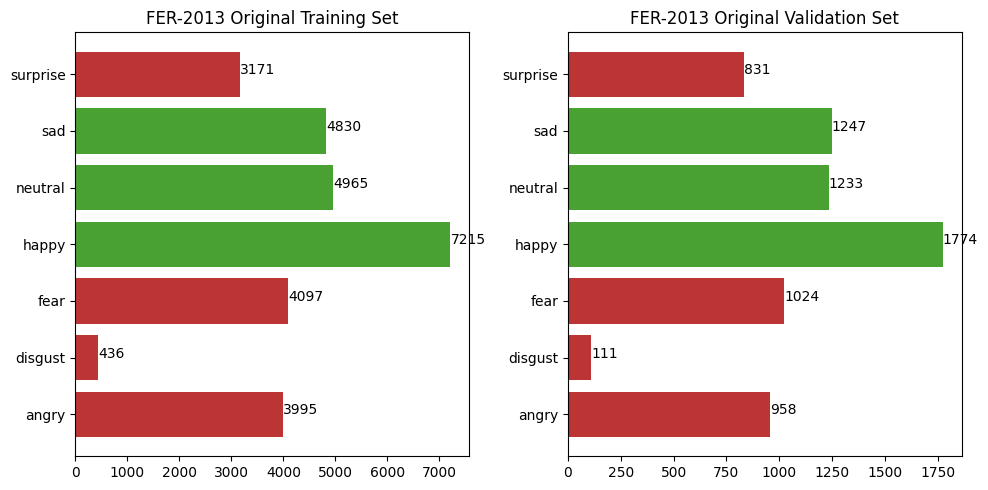

In [25]:
plot_datasets([train_set_fer2013, test_set_fer2013], ["FER-2013 Original Training Set", "FER-2013 Original Validation Set"])

**Observation**: FER-2013 does not have many samples for the disgust class. This motivates us to merge it with other datasets and apply dataset augmentation to balance the classes. 

#### Dataset Images View

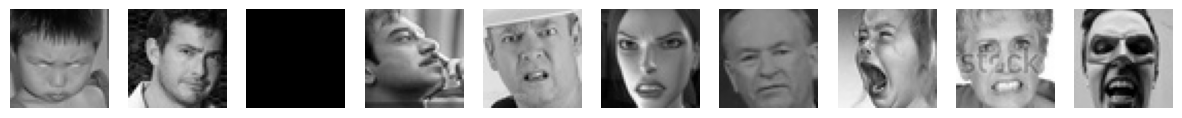

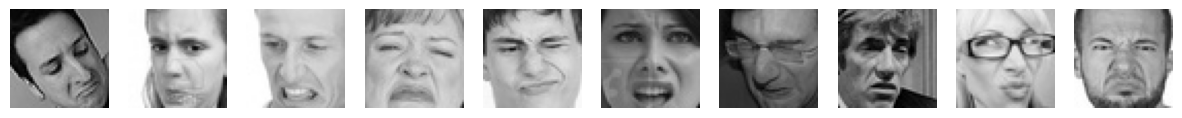

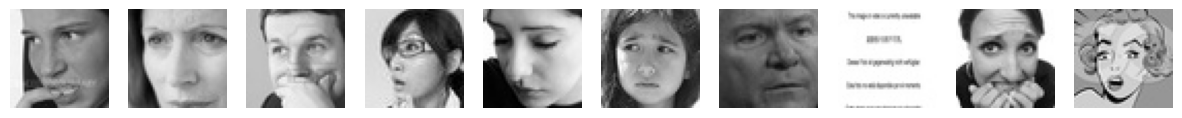

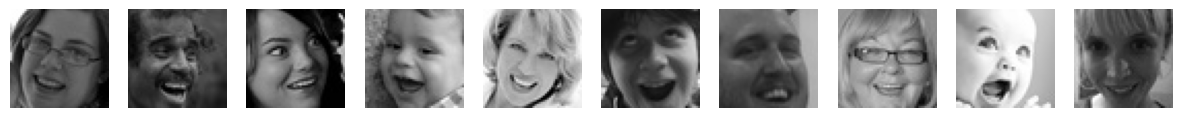

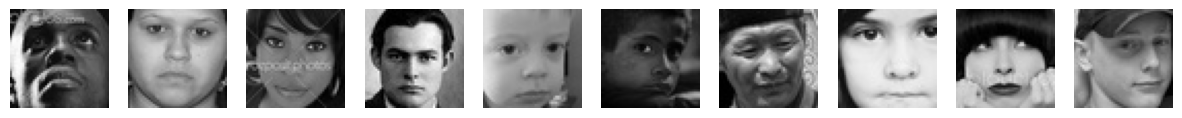

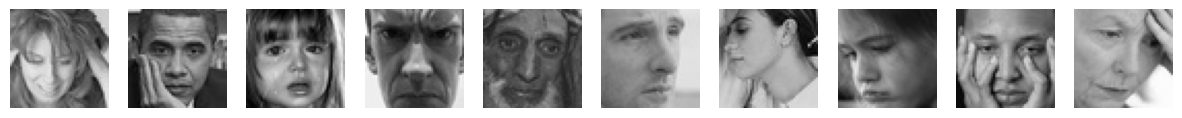

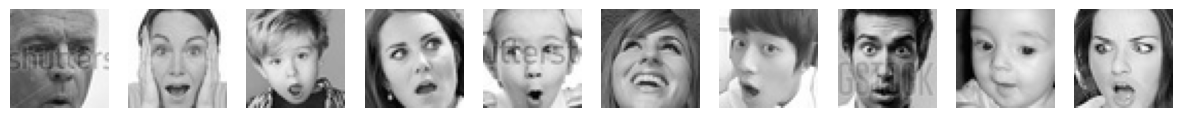

In [28]:
# taking files from training classes.
paths = []
for path in glob.glob(train_set_fer2013):
  paths.append(path + "/*.jpg")

# put in the results the images.
results = []
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

# print the final grid.
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

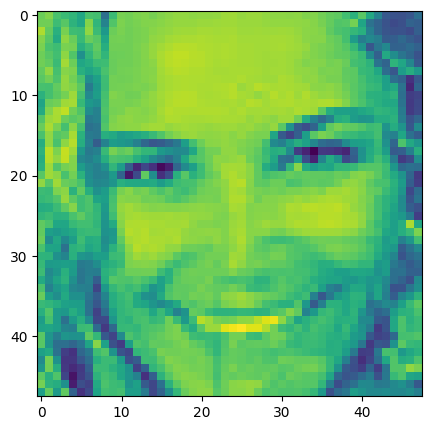

In [32]:
sample_img = 'FER2013/test/happy/PrivateTest_10077120.jpg'
pic = imageio.imread(sample_img)
plt.figure(figsize = (5,5))
plt.imshow(pic)

In [33]:
# metadata analysis.
print('Type of the image : ' , type(pic)) 
print('Shape of the image : {}'.format(pic.shape)) 
print('Dimension of Image: {}'.format(pic.ndim))
print('Image size: {}'.format(pic.size)) 
print('Maximum channel value in this image: {}'.format(pic.max())) 
print('Minimum channel value in this image: {}'.format(pic.min()))

Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (48, 48)
Dimension of Image: 2
Image size: 2304
Maximum channel value in this image: 252
Minimum channel value in this image: 22


**Observation**: The image size is 48x48. We will resize it to 224x224 size and put it together in the same folder as the other datasets for data integration. We will use our ImageWorker object to do that.

In [35]:
# takes the channels distribution for the original training and validation set.
train_ch = channels_distribution(train_set_fer2013)
test_ch = channels_distribution(test_set_fer2013)

# unify the two distribution in one list.
if len(train_ch) == len(test_ch):
  tot_ch = [0 for i in range(len(train_ch))]
  for i in range(0, len(train_ch)):
     tot_ch[i] = train_ch[i] + test_ch[i]

# display the result.
print('Total channels distribution :', tot_ch)

Total channels distribution : [0, 0, 35887, 0, 0]


**Observation:** Given the expected output, we merge the training and validation folders in the final dataset with a regular size of 224x224. 

In [47]:
# Resize FER-2013 training images in 224x224 and put the result in the final dataset.
format_fer = "jpg"
source_type = "fer_2013"

#Source and destination directory
destinations = ["./AFFER+/train/" + class_ + "/" for class_ in fer_classes_train]
sources = ["./FER2013/train/" + class_ for class_ in fer_classes_train]
# resize and moves images with format_fer.
for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_fer, source_type, destinations[i])

['./AFFER+/train/angry/', './AFFER+/train/disgust/', './AFFER+/train/fear/', './AFFER+/train/happy/', './AFFER+/train/neutral/', './AFFER+/train/sad/']
['./FER2013/train/angry', './FER2013/train/disgust', './FER2013/train/fear', './FER2013/train/happy', './FER2013/train/neutral', './FER2013/train/sad']


In [54]:
# Resize FER-2013 test images in 224x224 and put the result in the final dataset.
source_type = "fer_2013"
format_fer = "jpg"
#Source and destination directory
sources = ["./FER2013/test/" + class_ + "/" for class_ in fer_classes_train]
destinations = ["./AFFER+/test/" + class_ + "/" for class_ in fer_classes_train]

In [55]:
# resize and moves images with format_fer.
for i in range(0, len(destinations)):
  iw.format_converter(sources[i], format_fer, source_type, destinations[i])

#### 2.3.2 CK+ 

Dataset with 981 images in seven classes. Image size=48x48 with grey-scaled colour palette. 

In [56]:
num_classes =7 
data_dir_ck= './CK+/*'
ck_classes_t = iw.list_classes(data_dir_ck)
ck_tot = iw.counter_samples(data_dir_ck)
print('Classes:', ck_classes_t)
print("Total no. of images in CK+: ", ck_tot)

Classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
Total no. of images in CK+:  981


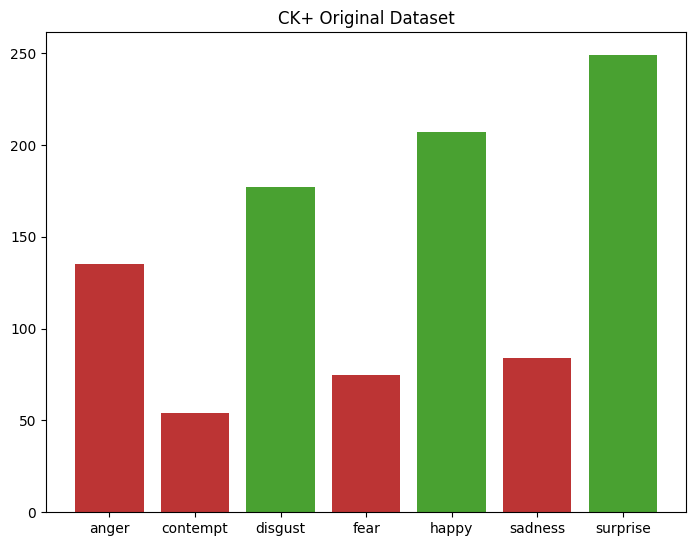

In [65]:
plot_dataset("./CK+/*", title="CK+ Original Dataset")

#### Dataset Images View

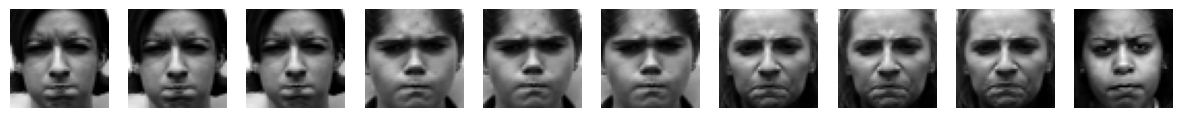

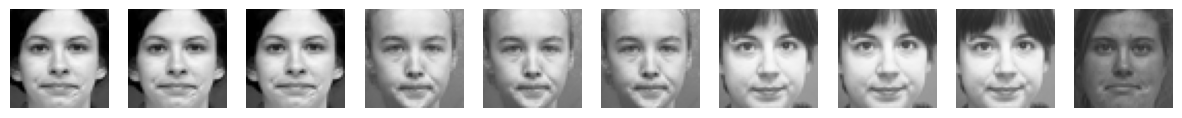

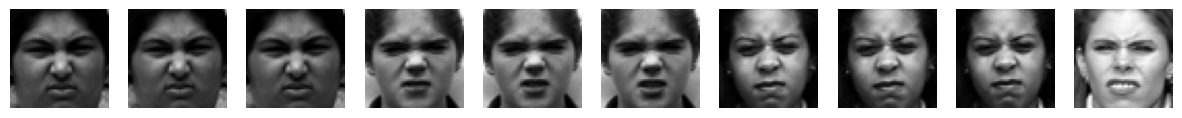

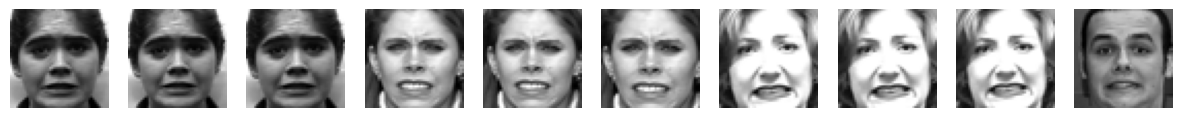

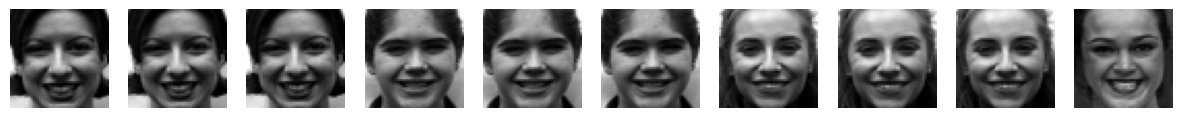

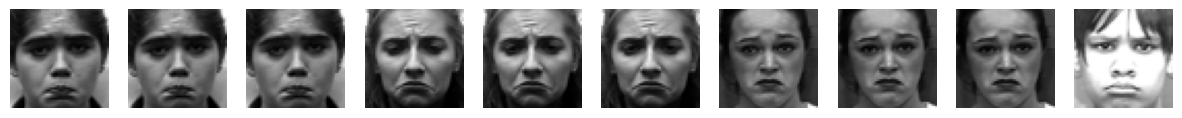

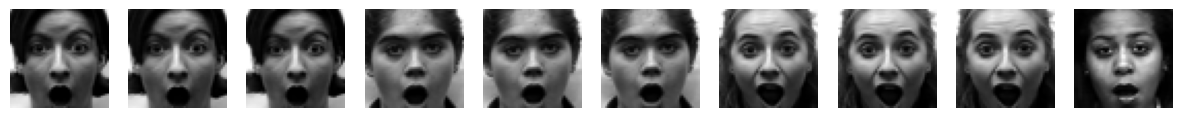

In [67]:
# collections of files from the dataset.
paths = []
for path in glob.glob(data_dir_ck):
  paths.append(path + "/*.png")

# read files and add the result in the list.
results = []
num_classes = len(ck_classes_t)
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

# display images in the grid.
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

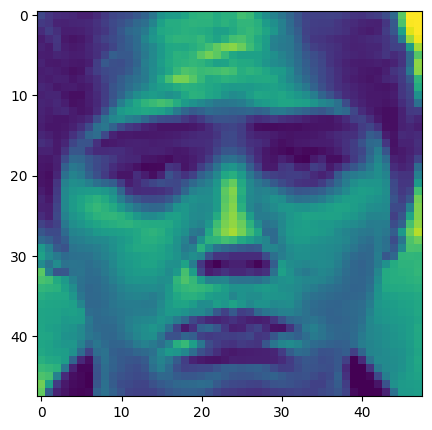

In [69]:
# Read a sample from CK+48.
sample_img = './CK+/sadness/S011_002_00000020.png'
pic = imageio.imread(sample_img)
plt.figure(figsize = (5,5))
plt.imshow(pic)

**Observation**: The image size is 48x48. We will resize it to 224x224 size and put it together in the same folder as the other datasets for data integration. We will use our ImageWorker object to do that.

In [70]:
# metadata analysis.
print('Type of the image : ' , type(pic)) 
print('Shape of the image : {}'.format(pic.shape)) 
print('Dimension of Image: {}'.format(pic.ndim))
print('Image size: {}'.format(pic.size)) 
print('Maximum channel value in this image: {}'.format(pic.max())) 
print('Minimum channel value in this image: {}'.format(pic.min()))
print('Total channels distribution :', channels_distribution(data_dir_ck))

Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (48, 48)
Dimension of Image: 2
Image size: 2304
Maximum channel value in this image: 255
Minimum channel value in this image: 0
Total channels distribution : [0, 0, 981, 0, 0]


In [73]:
# Resize images and put the result in the final dataset
format_ck = "png"
source_type = "ck_plus"

# defines sources and destinations paths.
destinations = ["./AFFER+/train/" + class_ + "/" for class_ in ck_classes_t]
sources = ["./CK+/" + class_ + '/' for class_ in ck_classes_t]
print(sources)

['./CK+/anger/', './CK+/contempt/', './CK+/disgust/', './CK+/fear/', './CK+/happy/', './CK+/sadness/', './CK+/surprise/']


In [74]:
# resize images from paths and store the result on destinations.
for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_ck, source_type, destinations[i])

#### 2.3.3 AffectNet 

Has samples of different sizes, high-quality images in grey scale or coloured RGB.  It has eight different classes (surprise, angry, sad, contempt, disgust, fear, neutral, and happy). As the FER-2013, there is a division between validation and training set; however, we will no merge it as well as we did with FER subsets, but put the validation set in the final val folder. Furthermore, we resize the different sizes of its images in 224x224 to establish the same amount of pixels for each sample.

In [82]:
# dataset specifics.
num_classes = 8
data_train_af = './AffectNet/*'
af_classes_t = iw.list_classes(data_train_af)

In [83]:
af_train_tot = iw.counter_samples(data_train_af)
print('Classes:', af_classes_t)
print("Total no. of images in AffectNet: ", af_train_tot)
print('-'*40)

Classes: ['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Total no. of images in AffectNet:  29042
----------------------------------------


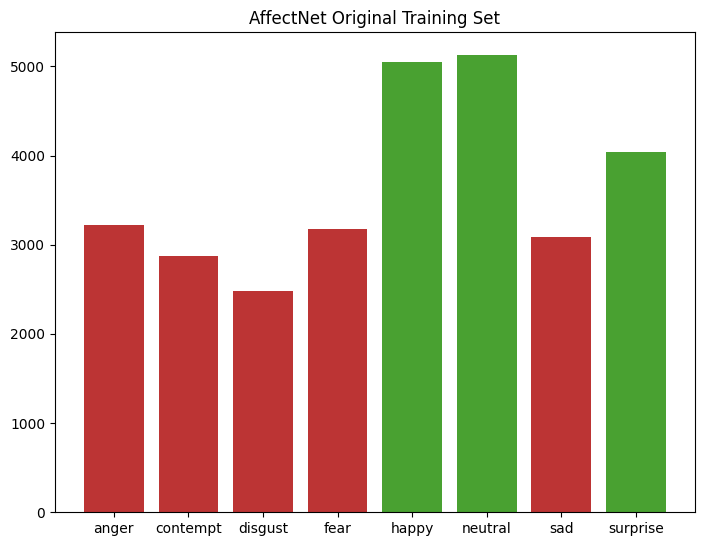

In [84]:
plot_dataset(data_train_af, title="AffectNet Original Training Set" )

#### Dataset Images View

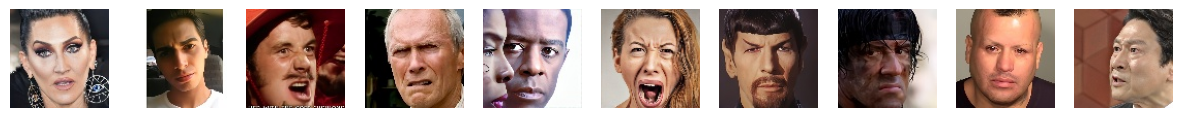

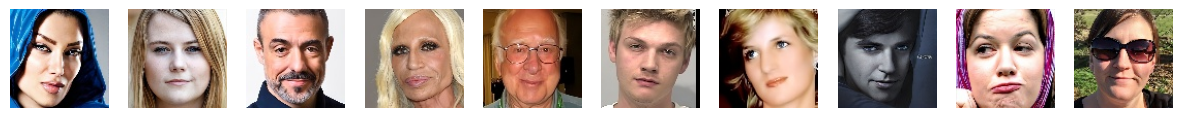

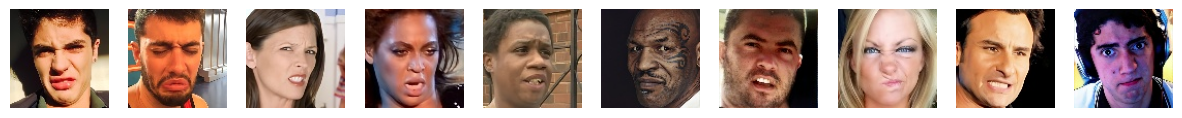

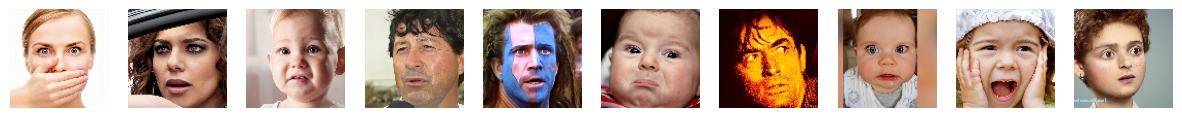

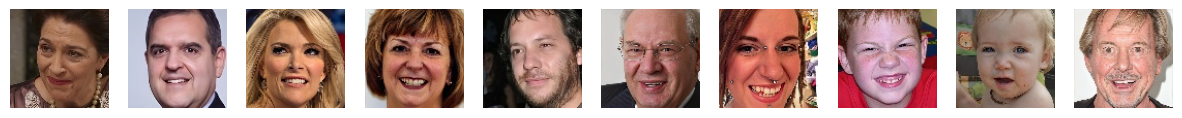

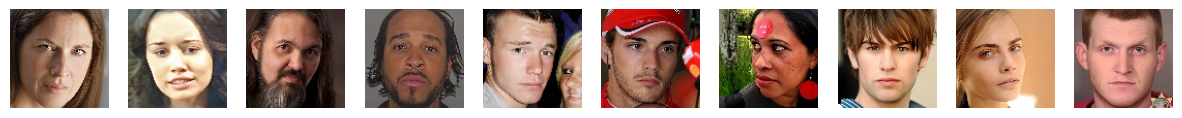

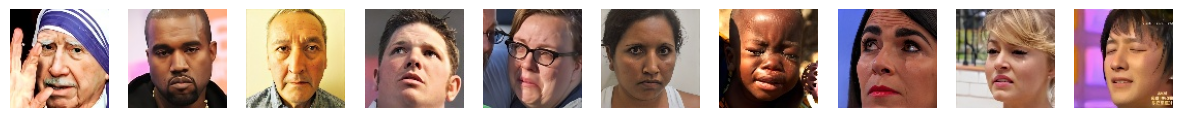

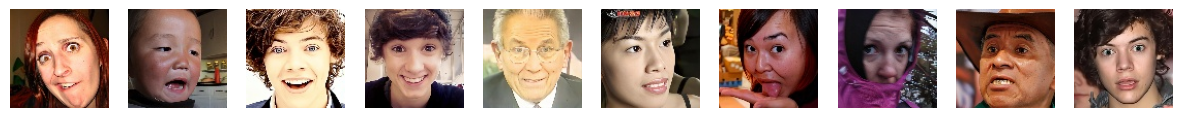

In [86]:
# list the paths of the dataset files.
paths = []
for path in glob.glob(data_train_af):
  paths.append(path + "/*.jpg")

# read images and put in the results list.
results = []
num_classes = len(af_classes_t)
for path in paths:
  counter = 0
  for file in glob.glob(path):
    if counter < 10:
      results.append(cv2.imread(file))
      counter += 1
    else: 
      break

# display images in the grid.
for j in range(0, num_classes):
  fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(15,15))
  for i in range(0,10):
    ax[i].imshow(cv2.cvtColor(results[i+j*10], cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

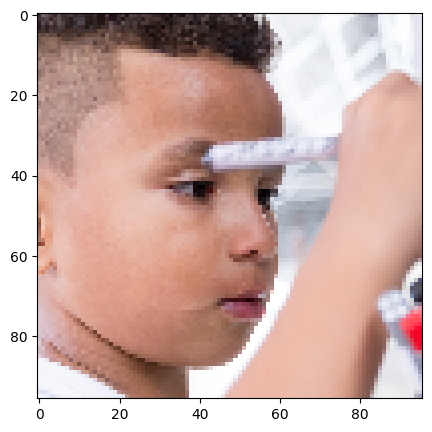

In [91]:
# load samples from AffectNet.
sample_affectnet = './AffectNet/neutral/ffhq_1013.png'
pic = imageio.imread(sample_affectnet)
plt.figure(figsize = (5,5))
plt.imshow(pic)

Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (96, 96, 3)
Image Hight 96
Image Width 96
Dimension of Image 3
Image size 27648
Maximum RGB value in this image 255
Minimum RGB value in this image 0
----------------------------------------
Value of only R channel 64
Value of only G channel 43
Value of only B channel 39
---------------------------------------------------------------------------------------------------------


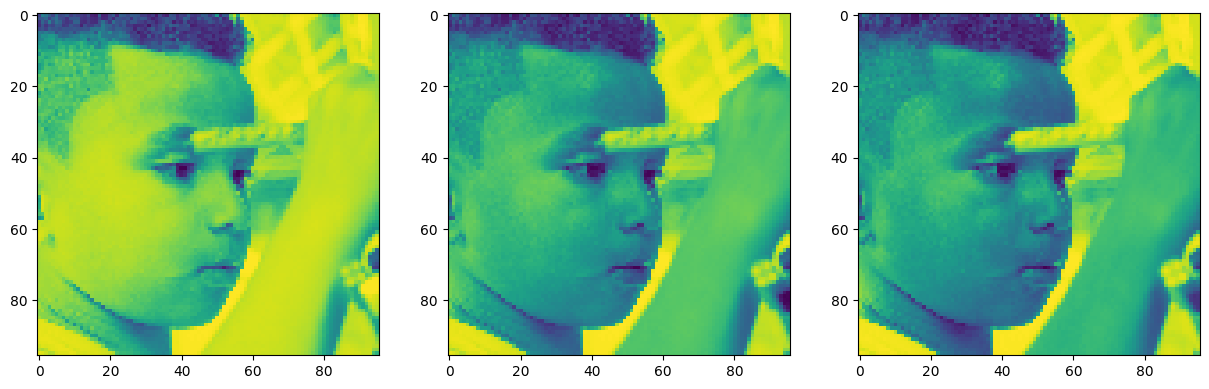

In [92]:
# metadata analysis.
print('Type of the image : ' , type(pic)) 
print('Shape of the image : {}'.format(pic.shape)) 
print('Image Hight {}'.format(pic.shape[0])) 
print('Image Width {}'.format(pic.shape[1])) 
print('Dimension of Image {}'.format(pic.ndim))
print('Image size {}'.format(pic.size)) 
print('Maximum RGB value in this image {}'.format(pic.max())) 
print('Minimum RGB value in this image {}'.format(pic.min()))
print('-'*40)
print('Value of only R channel {}'.format(pic[5, 5, 0])) 
print('Value of only G channel {}'.format(pic[5, 5, 1])) 
print('Value of only B channel {}'.format(pic[5, 5, 2]))
print('-'*105)
# display pixels with singular channel value.
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))  
for c, ax in zip(range(3), ax):     
    ax.imshow(pic[ :, :, c])

Now, we know that each pixel of the image is represented by three integers. Splitting the image into separate color components is just a matter of pulling out the correct slice of the image array. So, we can use the zero matrix generated by the original version given by the zero function from numpy library.

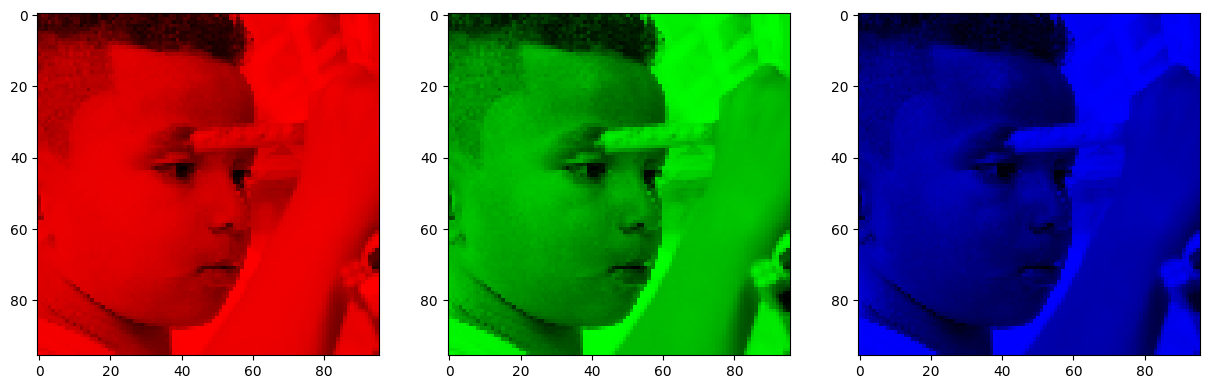

In [94]:
# display the same pixels on a zero matrix.
pic = imageio.imread(sample_affectnet) 
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))  
for c, ax in zip(range(3), ax):         
     split_img = np.zeros(pic.shape, dtype="uint8") # make a zero matrix.
     split_img[ :, :, c] = pic[ :, :, c] # visualize one of the 3 channel.
     ax.imshow(split_img)

In [125]:
# checking channels distribution on AffectNet samples.
data_train_af = './AffectNet/*'
train_ch = channels_distribution(data_train_af)
print('Total channels distribution :', train_ch)

Total channels distribution : [0, 0, 0, 18332, 0]


In [ ]:
# format of the image in the AffectNet.
format_affectnet = "jpg"
# the name tag.
source_type = "affect_net"

# We pass the AffectNet dataset in the validation set to balance it in the validation and testing subset.
# Given a size bigger than CK+48 and FER-2013, we can use only a part in training and mantains the 
# rest in the testing and validation (only a small part related to the training set).
destinations = ["/content/drive/MyDrive/Datasets/AVFER/val/" + class_ + "/" for class_ in af_classes_t]
sources = ["/content/drive/MyDrive/Datasets/AffectNet/train_class/" + class_ + "/" for class_ in af_classes_t]

# moves and resize AffectNet training samples.
for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_affectnet, source_type, destinations[i])

In [ ]:
# the name tag.
source_type = "affect_net_2"

# list destinations and sources, we put it on the validation set of the result dataset.
destinations = ["/content/drive/MyDrive/Datasets/AVFER/test/" + class_ + "/" for class_ in af_classes_t]
sources = ["/content/drive/MyDrive/Datasets/AffectNet/val_class/" + class_ for class_ in af_classes_t]

# moves and resize AffectNet validation samples.
for i in range(0,len(destinations)):
  iw.format_converter(sources[i], format_affectnet, source_type, destinations[i])

## Result of Integration

AVFER is a ViT dataset where the validation set is composed only by images from the AffectNet dataset. The testing set is composed to these kind of image too to mantain a correct verification of the model performances. Furthermore, the training set is composed even by FER-2013 and CK+48 datasets. 

In [ ]:
# specifics of AVFER.
num_classes = 8
data_avfer = []
base_directory = "/content/drive/My Drive/Datasets/AVFER/*"
sets = iw.list_classes(base_directory)
i = 0

# display the subset division.
print('Division of AVFER: ')
for subset in sets:
  data_avfer.append('/content/drive/My Drive/Datasets/AVFER/' + subset + '/*')
  print(data_avfer[i])
  i = i + 1

In [ ]:
# counts of the subsets samples and total number.
avfer_tot = 0
i = 0
total = 0
for i in range(3):
  base_directory = data_avfer[i][:len(data_avfer[i])-1]
  counter_folder = 0
  for cl in os.listdir(base_directory):
    for fl in os.listdir(base_directory + cl + "/"):
      counter_folder += 1
  print(f'Elements in {data_avfer[i][:len(data_avfer[i])-1]} are {counter_folder}')
  total += counter_folder
print("Total elements in the dataset is", total)

In [ ]:
plot_dataset(data_avfer[0], "AVFER Training Set Distribution")

In [ ]:
plot_dataset(data_avfer[1], "Validation Set Distribution")

In [ ]:
plot_dataset(data_avfer[2], "Testing Set Distribution")

The situation is not so balanced. We need to use AffectNet on the validation and testing set for a subset of values. Meanwhile, the training set has to adopt augmentation values to improve the samples' number for the training phase. Validation and testing sets are not subjects of data augmentation.